# CMU Movie data

## Initial data inspection
We will first try to provide a first generic inspection of the CMU movie dataset we decided to work on.

In [24]:
import pandas as pd
import numpy as np
import re
import json
from src.utils.data_utils import *
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data
The dataset is divided in 3 parts, the characters, the movies and the plots of the movies.

In [25]:
character_data, movie_data, plot_data = load_data()

### Characters dataset
Let's first have a look to the character dataset.

In [26]:
print(f'There are {character_data.shape[0]} characters with {character_data.shape[1]} features for each.')

There are 451432 characters with 14 features for each.


In [27]:
character_data.head(2)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,character_actor_map_id,character_id,actor_id,actor_ethnicity_label
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN


We can note that the actor ethnicity need to be transform to readable value (for now, it looks to be freebase id).

Let's now see if we have a lot of missing data. We will also check that we don't have duplicated rows.

In [28]:
print("Percentage of null rows in the characters dataset for each features:")
print(character_data.isnull().mean().round(3)*100)

Percentage of null rows in the characters dataset for each features:
wikipedia_movie_id         0.0
freebase_movie_id          0.0
movie_release_date         2.2
character_name            57.2
actor_dob                 23.5
actor_gender              10.1
actor_height              65.6
actor_ethnicity           76.3
actor_name                 0.3
actor_age_at_release      35.0
character_actor_map_id     0.0
character_id              57.2
actor_id                   0.2
actor_ethnicity_label     77.0
dtype: float64


In [29]:
print(f"Duplicated rows: {character_data.duplicated().sum()}")

Duplicated rows: 0


We see that we miss a lot of character names/ids, actor heights, actor ethnicity and actor age at release.

### Movies dataset
Let's now have a look to the movies dataset.

In [30]:
print(f'There are {movie_data.shape[0]} movies with {movie_data.shape[1]} features for each.')

There are 81741 movies with 9 features for each.


In [31]:
movie_data.head(2)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."


We can note that the languages, countries and genres need to be preprocessed (for now dictionnary with id->readablename).

Let's now see if we have a lot of missing data. We will also verify that we dont' have duplicated rows.

In [32]:
print("Percentage of null rows in the movies dataset for each features:")
print(movie_data.isnull().mean().round(3)*100)

Percentage of null rows in the movies dataset for each features:
wikipedia_movie_id     0.0
freebase_movie_id      0.0
movie_name             0.0
movie_release_date     8.4
box_office_revenue    89.7
runtime               25.0
languages              0.0
countries              0.0
genres                 0.0
dtype: float64


In [33]:
print(f"Duplicated rows: {movie_data.duplicated().sum()}")

Duplicated rows: 0


Ouch! We only have box office revenue for 10% of our movies, that's not good news since it's a key feature in our research problematic, we will need to fix this. Apart from this, we can also note that we are missing 25% of the runtime information. We could try to improve this. This also applies to the movie release data. For the languages, countries and genres, we note that they are dictionaries meaning that we first need to preprocess them a bit (for example transforming them to a list) to then be able to see the percentage of missing data. We will do it now:

In [34]:
# Extract the readable values for 'languages', 'countries', and 'genres' columns. Also clean the language column.

movie_data['languages'] = movie_data['languages'].apply(lambda x: extract_values(x, clean_func=clean_language))
movie_data['countries'] = movie_data['countries'].apply(lambda x: extract_values(x)) 
movie_data['genres'] = movie_data['genres'].apply(lambda x: extract_values(x))  

We can now have a look to the missing data:

In [35]:
# Calculate the number of None (NaN) values for each column
none_languages = movie_data['languages'].isna().mean()
none_countries = movie_data['countries'].isna().mean()
none_genres = movie_data['genres'].isna().mean()

# Print the counts of None (NaN) values
print(f"Percentage of None values in 'languages': {none_languages:.2%}")
print(f"Percentage of None values in 'countries': {none_countries:.2%}")
print(f"Percentage of None values in 'genres': {none_genres:.2%}")

Percentage of None values in 'languages': 16.96%
Percentage of None values in 'countries': 9.98%
Percentage of None values in 'genres': 4.38%


This looks ok overall.

### Plot summary dataset
Let's now have a look to the plot summaries dataset.

In [36]:
print(f'There are {plot_data.shape[0]} plot summaries with {plot_data.shape[1]} features for each.')

There are 42303 plot summaries with 2 features for each.


In [37]:
plot_data.head(2)

,wikipedia_movie_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...


Let's see if we have some rows that are invalid (no summary or wikipedia id).

In [38]:
print("Pourcentage of null rows in the plot summaries dataset:")
print(plot_data.isnull().mean().round(3)*100)

Pourcentage of null rows in the plot summaries dataset:
wikipedia_movie_id    0.0
summary               0.0
dtype: float64


Good new, we have nothing missing here :)

## Data completion + first preprocessing
Before going deeper to the analysis, we want to already fix some problems we pointed out.

Movies:
- A lot of box office revenus missing

Characters:
- We first note that we need to preprocess the actor ethnicity that look to be a freebase id.

### Movies problems

Let's first to get more data on box office results to decrease the number of missing data we have for now. To do this, we will merge the current dataset with a dataset that contains information about 1,000,000 movies collected from The Movie Database (TMDb), including revenue and runtime (https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies?resource=download).

In [39]:
# Load the new dataset (and rename some columns)
movies_dataset = pd.read_csv('data/tmbd_movies.csv')
movies_dataset['box_office_revenue'] = pd.to_numeric(movies_dataset['revenue'], errors='coerce') 
movies_dataset['release_date'] = pd.to_datetime(movies_dataset['release_date'], errors='coerce')

# We remove the nan of movie release date since we merge on it
movie_data['movie_release_date'] = pd.to_datetime(movie_data['movie_release_date'], errors='coerce')
movie_data = movie_data.dropna(subset=['movie_release_date'])

movies_dataset.head(2)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords,box_office_revenue
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",825532764
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",701729206


In [40]:
movie_data_merged, before_missing, after_missing = merge_for_completion(movie_data, movies_dataset, ["movie_name", "movie_release_date"], ["title", "release_date"], "box_office_revenue", merge_strategy='prioritize_first')

In [41]:
# Print the before and after missing percentages
print(f"Box office results missing percentage before merge (on title) with wikidata: {before_missing:.2%}")
print(f"Box office results missing percentage after merge (on title) with wikidata: {after_missing:.2%}")

Box office results missing percentage before merge (on title) with wikidata: 82.75%
Box office results missing percentage after merge (on title) with wikidata: 42.65%


Big improvement, that's good. Let's try to improve the runtime.

In [42]:
movie_data_merged, before_missing, after_missing = merge_for_completion(movie_data_merged, movies_dataset, ["movie_name", "movie_release_date"], ["title", "release_date"], "runtime", merge_strategy='prioritize_first')

In [43]:
# Print the before and after missing percentages
print(f"Runtime results missing percentage before merge (on title) with The Movies Dataset: {before_missing:.2%}")
print(f"Runtime results missing percentage after merge (on title) with The Movies Dataset: {after_missing:.2%}")

Runtime results missing percentage before merge (on title) with The Movies Dataset: 17.03%
Runtime results missing percentage after merge (on title) with The Movies Dataset: 9.34%


That pretty cool too, we also want to get the IMBD ID column because we need it afterwards.

In [44]:
movie_data_merged, _, _ = merge_for_completion(movie_data_merged, movies_dataset, ["movie_name", "movie_release_date"], ["title", "release_date"], "imdb_id", merge_strategy='add_column')

### Characters problems

TODO: Improve missing characters (maybe not needed, see the "Do we have data on all lead actors") -> I think it's not really needed because of the results we have

## Getting the rating and lead actors of movies

Now we want to merge with the IMDb datasets (https://developer.imdb.com/non-commercial-datasets/) in order to obtain ratings and lead actors. We set consider an actor a lead actor if their ordering is 1 or 2.

In [45]:
# Load IMDb ratings and select relevant columns
imdb_ratings = pd.read_csv('data/title.ratings.tsv', sep='\t')
imdb_ratings = imdb_ratings.rename(columns={'tconst': 'imdb_id'})
imdb_ratings = imdb_ratings[['imdb_id', 'averageRating', 'numVotes']]

In [46]:
# Load IMDb names data for actors
imdb_names = pd.read_csv('data/name.basics.tsv', sep='\t')

In [47]:
# Initialize an empty list to hold chunks of filtered lead actors
filtered_lead_actors = []

# Process imdb_principals in chunks to reduce memory usage
for chunk in pd.read_csv('data/title.principals.tsv', sep='\t', chunksize=100000):
    # Filter for lead actors (first and second-billed actor or actress)
    chunk_lead_actors = chunk[
        (chunk['category'].isin(['actor', 'actress'])) & 
        (chunk['ordering'].isin([1, 2]))
    ][['tconst', 'nconst', 'ordering']]
    
    # Append the filtered chunk to the list
    filtered_lead_actors.append(chunk_lead_actors)

In [48]:
# Concatenate all filtered chunks into a single DataFrame
lead_actors = pd.concat(filtered_lead_actors)

# Rename columns and merge with imdb_names DataFrame to get actor names
lead_actors = lead_actors.rename(columns={'tconst': 'imdb_id'})
lead_actors = lead_actors.merge(imdb_names[['nconst', 'primaryName']], on='nconst', how='left')

# Pivot to get separate columns for the first and second lead actors
lead_actors = lead_actors.pivot(index='imdb_id', columns='ordering', values='primaryName').reset_index()
lead_actors.columns = ['imdb_id', 'lead_actor_1', 'lead_actor_2']

# Merge movies_wikidata_merged_imdbid with IMDb ratings
imdb_merged_movie_data = pd.merge(movie_data_merged, imdb_ratings, on='imdb_id', how='left')

# Merge with lead actors data
merged_movie_data = imdb_merged_movie_data.merge(lead_actors, on='imdb_id', how='left')

In [49]:
merged_movie_data = merged_movie_data.drop_duplicates(subset=['imdb_id'])
merged_movie_data.head(2)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office_revenue,runtime,languages,countries,genres,title,release_date,title_from_second,release_date_from_second,imdb_id,averageRating,numVotes,lead_actor_1,lead_actor_2
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Ghosts of Mars,2001-08-24,Ghosts of Mars,2001-08-24,tt0228333,4.9,58894.0,Natasha Henstridge,Ice Cube
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,0.0,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,tt0245916,6.1,77.0,Alice Barrett,Rod Britt


In [50]:
print(f"We have {merged_movie_data.shape[0]} rows in our merged movies dataset.")

We have 19100 rows in our merged movies dataset.


## Cleaning and removing outliers

Before analyzing the data any further, let's remove outliers.

### Character dataset

In [51]:
# Convert dob to date
character_data.loc[:, "actor_dob"] = pd.to_datetime(character_data["actor_dob"], errors='coerce')

In [52]:
# Keep only non-NaN values for all columns
not_na_height = character_data["actor_height"].notna()
not_na_age_at_release = character_data["actor_age_at_release"].notna()
not_na_gender = character_data["actor_gender"].notna()
not_na_ethnicity = character_data["actor_ethnicity"].notna()
not_na_name_char = character_data["character_name"].notna()
not_na_dob = character_data["actor_dob"].notna()

# Combine all conditions into one mask
not_na_mask = not_na_height & not_na_age_at_release & not_na_gender & not_na_ethnicity & not_na_name_char & not_na_dob

# Apply the mask to the DataFrame
character_data_cleaned = character_data.copy()[not_na_mask]

# Calculate reduction in size
reduction = 1 - character_data_cleaned.shape[0] / character_data.shape[0]
print(f"Removing NaN reduced the dataset by: {reduction:.2%}")

Removing NaN reduced the dataset by: 89.97%


In [53]:
# Keep only valid heights (between 1.5 and 2.8 meters)
character_data_valid_heights = character_data_cleaned.query("actor_height > 1.5 and actor_height < 2.8")
reduction = (len(character_data_cleaned) - len(character_data_valid_heights)) / len(character_data_cleaned)

print(f"Removing invalid actor heights reduced that dataset by {reduction:.2%}.")

Removing invalid actor heights reduced that dataset by 0.43%.


In [54]:
# Keep only valid ages (between 0 and 100 years)
character_data_valid_ages = character_data_valid_heights.query("actor_age_at_release > 0 and actor_age_at_release < 100")
reduction = (len(character_data_valid_heights) - len(character_data_valid_ages)) / len(character_data_valid_heights)

print(f"Removing invalid actor ages reduced that dataset by {reduction:.2%}.")

Removing invalid actor ages reduced that dataset by 0.06%.


In [55]:
# Keep only ethnicity labels that are common
min_occurrence = 10
ethnicity_label_counts = character_data_valid_ages['actor_ethnicity_label'].value_counts()
ethnicity_labels = ethnicity_label_counts[ethnicity_label_counts > min_occurrence]

mask = character_data_valid_ages['actor_ethnicity_label'].isin(ethnicity_labels.index)
character_data_valid = character_data_valid_ages[mask]

reduction = 1 - len(character_data_valid) / len(character_data_valid_ages)

print(f"Removing ethnicity labels which are uncommon reduced that dataset by {reduction:.2%}.")

Removing ethnicity labels which are uncommon reduced that dataset by 3.83%.


In [88]:
# Print the final dataset size
print(f"Number of characters after preprocessing: {character_data_valid.shape[0]}.")

Number of characters after preprocessing: 43329.


In [89]:
# Check that no nan values still there
character_data_valid.isnull().mean()

wikipedia_movie_id        0.0
freebase_movie_id         0.0
movie_release_date        0.0
character_name            0.0
actor_dob                 0.0
actor_gender              0.0
actor_height              0.0
actor_ethnicity           0.0
actor_name                0.0
actor_age_at_release      0.0
character_actor_map_id    0.0
character_id              0.0
actor_id                  0.0
actor_ethnicity_label     0.0
dtype: float64

### Movies dataset

We will also remove the outliers and preprocess the movie dataset.

In [57]:
# Drop duplicated columns
movie_data_extracted = merged_movie_data.drop(columns=['title', 'release_date'])

In [58]:
# Set lead_actor_2 to NaN where it is the same as lead_actor_1
movie_data_extracted.loc[movie_data_extracted['lead_actor_1'] == movie_data_extracted['lead_actor_2'], 'lead_actor_2'] = pd.NA

# Remove movies where we don't have lead actor
movie_data_extracted = movie_data_extracted.dropna(subset=['lead_actor_1'])

In [59]:
# Keep only non-NaN values for all columns (the other columns have no missing values)
not_na_release_date = movie_data_extracted["movie_release_date"].notna()
not_na_runtime = movie_data_extracted["runtime"].notna()
not_na_languages = movie_data_extracted["languages"].notna()
not_na_countries = movie_data_extracted["countries"].notna()
not_na_genres = movie_data_extracted["genres"].notna()
not_na_lead_actor_1 = movie_data_extracted["lead_actor_1"].notna()
not_na_box_office = movie_data_extracted["box_office_revenue"].notna()
not_na_average_rating = movie_data_extracted["averageRating"].notna()

# Combine all conditions into one mask
not_na_mask = not_na_release_date & not_na_runtime & not_na_languages & not_na_countries & not_na_genres & not_na_lead_actor_1 & not_na_box_office & not_na_average_rating


# Apply the mask to the DataFrame
movie_data_cleaned = movie_data_extracted[not_na_mask]

# Calculate reduction in size
reduction = 1 - movie_data_cleaned.shape[0] / movie_data_extracted.shape[0]
print(f"Removing NaN reduced the dataset by: {reduction:.2%}")

Removing NaN reduced the dataset by: 17.84%


In [60]:
#Keep only movies released between 1940 and 2012
movie_data_valid_release_dates = movie_data_cleaned[movie_data_cleaned["movie_release_date"]>'1-1-1940']

reduction = 1 - movie_data_valid_release_dates.shape[0]/ movie_data_cleaned.shape[0]
print(f"Removing movies released before 1940 reduced the dataset by: {reduction:.2%}")

Removing movies released before 1940 reduced the dataset by: 15.38%


In [61]:
#Keep only movies that last under 200 min
movie_data_valid_runtime = movie_data_valid_release_dates[movie_data_valid_release_dates["runtime"]<200]

reduction = 1 - movie_data_valid_runtime.shape[0]/ movie_data_valid_release_dates.shape[0]
print(f"Removing movies lasting more than 3 hours 20mins reduced the dataset by: {reduction:.2%}")

Removing movies lasting more than 3 hours 20mins reduced the dataset by: 0.74%


In [62]:
#Keep only movies that last at least 1h
movie_data_valid_runtime = movie_data_valid_runtime[movie_data_valid_runtime["runtime"]>60]

reduction = 1 - movie_data_valid_runtime.shape[0]/ movie_data_valid_release_dates.shape[0]
print(f"Removing movies less than 1h: {reduction:.2%}")

Removing movies less than 1h: 7.94%


In [63]:
#Keep only movies that have at least 500 votes
movie_data_valid_votes = movie_data_valid_runtime[movie_data_valid_runtime["numVotes"]>500]

reduction = 1 - movie_data_valid_votes.shape[0]/ movie_data_valid_runtime.shape[0]
print(f"Removing movies that have less than 500 votes: {reduction:.2%}")

Removing movies that have less than 500 votes: 29.41%


In [64]:
movie_data_valid = movie_data_valid_votes.copy()

In [87]:
print(f"Number of movies after preprocessing: {movie_data_valid.shape[0]}.")

Number of movies after preprocessing: 8322


In [86]:
# Check that no nan values still there
movie_data_valid.isnull().mean()

wikipedia_movie_id          0.00000
freebase_movie_id           0.00000
movie_name                  0.00000
movie_release_date          0.00000
box_office_revenue          0.00000
runtime                     0.00000
languages                   0.00000
countries                   0.00000
genres                      0.00000
title_from_second           0.00000
release_date_from_second    0.00000
imdb_id                     0.00000
averageRating               0.00000
numVotes                    0.00000
lead_actor_1                0.00000
lead_actor_2                0.05155
dtype: float64

## Do we have data for the lead actors

Now that we have the two main actors of each movie, let's see if we have data on them.

In [65]:
# Extract unique pairs of (freebase_movie_id, lead_actor) from the movie dataset
lead_actor_pairs = pd.concat([
    movie_data_valid[['freebase_movie_id', 'lead_actor_1']].rename(columns={'lead_actor_1': 'actor_name'}),
    movie_data_valid[['freebase_movie_id', 'lead_actor_2']].rename(columns={'lead_actor_2': 'actor_name'})
])

# Convert the DataFrame of pairs to a list of tuples for filtering
lead_actor_pairs = list(lead_actor_pairs.itertuples(index=False, name=None))

# Filter character_data to keep only rows where (freebase_movie_id, actor_name) matches the pairs in lead_actor_pairs
lead_actor_data = character_data_valid[
    character_data_valid[['freebase_movie_id', 'actor_name']].apply(tuple, axis=1).isin(lead_actor_pairs)
]

# Check for missing values in key columns
print("Missing values in lead actor data:")
print(lead_actor_data[['actor_name', 'actor_dob', 'actor_gender', 'actor_ethnicity', 'actor_height', 'actor_age_at_release']].isna().mean()*100)

# Display the first few rows of the filtered data
lead_actor_data.head(2)


Missing values in lead actor data:
actor_name              0.0
actor_dob               0.0
actor_gender            0.0
actor_ethnicity         0.0
actor_height            0.0
actor_age_at_release    0.0
dtype: float64


,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,character_actor_map_id,character_id,actor_id,actor_ethnicity_label
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15 00:00:00,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
101,156558,/m/014k4y,2001-06-27,Jody,1978-12-30 00:00:00,M,1.797,/m/0x67,Tyrese Gibson,22.0,/m/0jtx5h,/m/03jnxf4,/m/01l1b90,African Americans


This make sense since we preprocessed our character data, let's now see if we have data for all of our actors.

In [66]:
print(f"We have data for {lead_actor_data.shape[0]/(movie_data_valid["lead_actor_1"].notna().sum() + movie_data_valid["lead_actor_2"].notna().sum())*100}% ({lead_actor_data.shape[0]} actors) of our lead actors")

We have data for 30.391612704286153% (4928 actors) of our lead actors


Ok good, let's now create a subset dataframe that will contains only the movies for which we have data on the lead actors.

In [67]:
subset_movies_with_lead_actors_data = movie_data_valid[movie_data_valid['freebase_movie_id'].isin(lead_actor_data['freebase_movie_id'])]

In [68]:
print(f"We have {subset_movies_with_lead_actors_data.shape[0]} movies for which we have full data on our lead actors")

We have 3685 movies for which we have full data on our lead actors


We can also extract the characters that are part of this subset.

In [69]:
# Filter the character_data_valid dataset to keep only rows with freebase_movie_id present in movie_data_extracted
subset_characters_with_lead_actor_data = character_data_valid[character_data_valid['freebase_movie_id'].isin(subset_movies_with_lead_actors_data['freebase_movie_id'])]

# Extract the relevant columns for characters and associated movies
subset_characters_with_lead_actor_data = subset_characters_with_lead_actor_data[['actor_name', 'actor_dob', 'actor_gender', 'actor_ethnicity', 'actor_height', 'actor_age_at_release', 'freebase_movie_id', 'character_name']]

# Display the first few rows of the filtered and extracted data
subset_characters_with_lead_actor_data.head(2)


,actor_name,actor_dob,actor_gender,actor_ethnicity,actor_height,actor_age_at_release,freebase_movie_id,character_name
2,Ice Cube,1969-06-15 00:00:00,M,/m/0x67,1.727,32.0,/m/03vyhn,Desolation Williams
5,Pam Grier,1949-05-26 00:00:00,F,/m/0x67,1.727,52.0,/m/03vyhn,Commander Helena Braddock


In [70]:
print(f"We have {subset_characters_with_lead_actor_data.shape[0]} characters for the subset movies.")

We have 11414 characters for the subset movies.


## Saving our newly created dataframes

We will save our five dataframes:

- full_movie_data_preprocessed that contains all the movies preprocessed 
- full_characters_data_preprocessed that contains all the characters preprocessed
- subset_movies_with_lead_actors_data that contains movies where we have data on all the lead actors
- lead_actors_data_on_subset_movie that contains information on the lead actors of the previous subset
- character_data_valid_filtered that contains information on all the characters of the previous subset

In [71]:
# Save to Pickle
movie_data_extracted.to_pickle('data/full_movie_data_preprocessed.pkl')
character_data_valid.to_pickle('data/full_characters_data_preprocessed.pkl')
subset_movies_with_lead_actors_data.to_pickle('data/subset_movie_with_full_data_on_lead_actors.pkl')
lead_actor_data.to_pickle('data/lead_actors_data_on_subset_movie.pkl')
subset_characters_with_lead_actor_data.to_pickle('data/characters_data_on_subset_movie.pkl')

## Loading our dataframes

We can skip all the preprocessing process and load our dataframes directly here:

In [72]:
# Load the datasets from pickle files
full_movie_data_preprocessed = pd.read_pickle('data/full_movie_data_preprocessed.pkl')
full_characters_data_preprocessed = pd.read_pickle('data/full_characters_data_preprocessed.pkl')
subset_movie_with_full_data_on_lead_actors = pd.read_pickle('data/subset_movie_with_full_data_on_lead_actors.pkl')
lead_actors_data_on_subset_movie = pd.read_pickle('data/lead_actors_data_on_subset_movie.pkl')
characters_data_on_subset_movie = pd.read_pickle('data/characters_data_on_subset_movie.pkl')

## Deeper analysis
Now that our data is more complete, we can do a more in deep analysis.

### Lead actors dataset 

Let's first analyse our dataframe with the lead actors just created. We will start with a summary of the statistics of the numerical features.

In [73]:
lead_actor_data.describe()

,wikipedia_movie_id,actor_height,actor_age_at_release
count,4.928000e+03,4928.000000,4928.000000
mean,8.030871e+06,1.758215,36.221997
std,9.023975e+06,0.094944,11.772824
min,3.746000e+03,1.520000,7.000000
25%,1.301663e+06,1.690000,28.000000
50%,3.843862e+06,1.765000,35.000000
75%,1.214936e+07,1.830000,43.000000
max,3.672404e+07,2.160000,89.000000


Let's print their distributions:

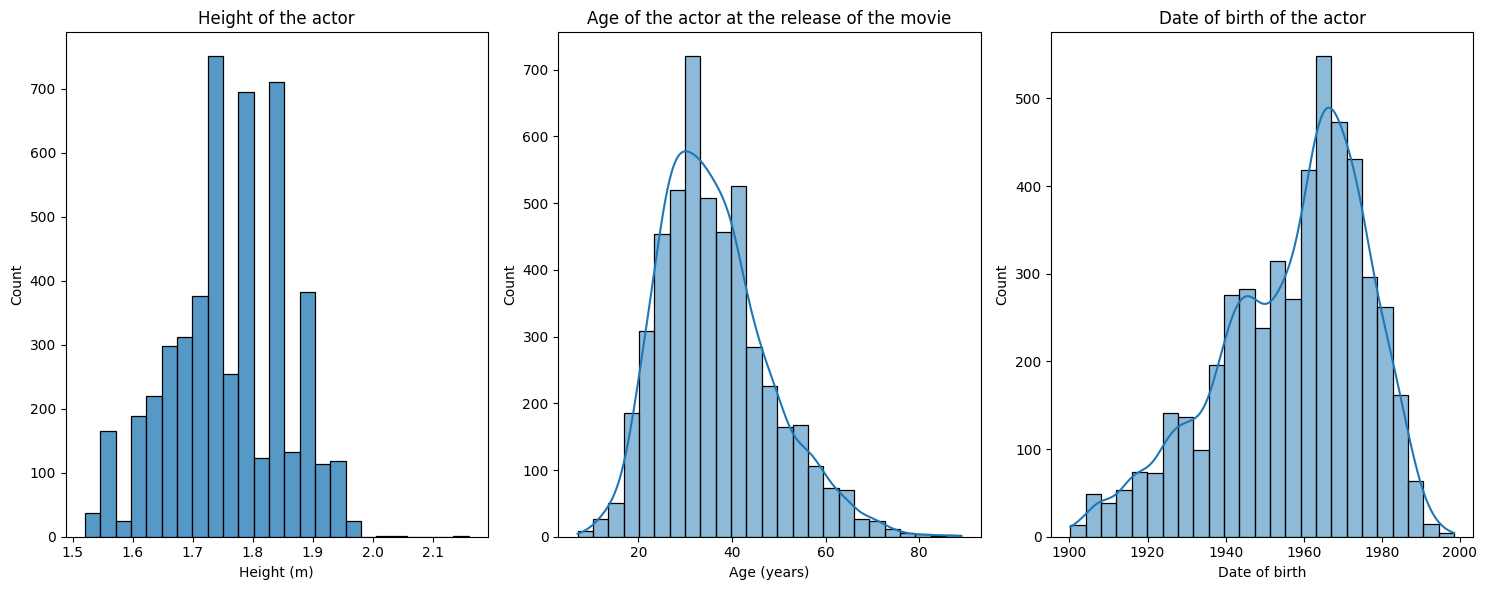

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Histogram for the runtime
sns.histplot(data=lead_actor_data, x="actor_height", bins=25, ax=axes[0], kde=False)
axes[0].set_title("Height of the actor")
axes[0].set_xlabel("Height (m)")

# Histogram for the box office results
sns.histplot(data=lead_actor_data, x="actor_age_at_release", bins=25, ax=axes[1], kde=True)
axes[1].set_title("Age of the actor at the release of the movie")
axes[1].set_xlabel("Age (years)")

# Histogram for the character date of birth
sns.histplot(data=lead_actor_data, x="actor_dob", bins=25, ax=axes[2], kde=True)
axes[2].set_title("Date of birth of the actor")
axes[2].set_xlabel("Date of birth")

plt.tight_layout()
plt.show()


Let's now lets explore the categorical data

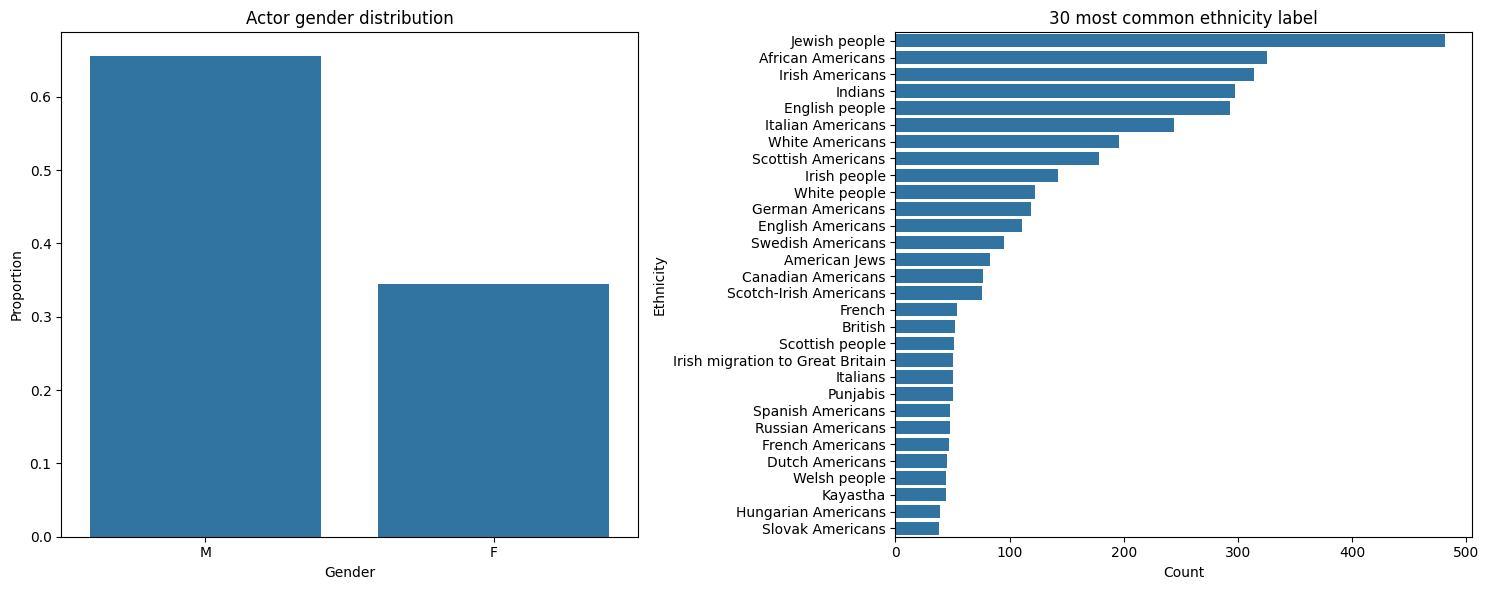

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Countplot for the gender distribution
sns.countplot(data=lead_actor_data, x="actor_gender", ax=axes[0], stat='proportion')
axes[0].set_title("Actor gender distribution")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Proportion")

ethnicity_cutoff = 30
values = lead_actor_data["actor_ethnicity_label"].value_counts()
values = values[:ethnicity_cutoff]
sns.barplot(x=values, y=values.index, ax=axes[1])
axes[1].set_title(f"{ethnicity_cutoff} most common ethnicity label")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Ethnicity")

plt.tight_layout()
plt.show()

### Movies dataset 

Let's now analyse our movies dataset. We will start with a summary of the statistics of the numerical features.

In [76]:
movie_data_completed = movie_data_extracted.copy()
movie_data_completed.describe()

,wikipedia_movie_id,movie_release_date,box_office_revenue,runtime,release_date_from_second,averageRating,numVotes
count,1.842200e+04,18422,1.842200e+04,18422.000000,18422,17502.000000,1.750200e+04
mean,1.577431e+07,1974-05-26 07:04:59.772011728,9.523581e+06,89.472733,1974-05-26 07:04:59.772011728,6.141710,1.567752e+04
min,3.746000e+03,1894-11-17 00:00:00,0.000000e+00,0.000000,1894-11-17 00:00:00,1.100000,6.000000e+00
25%,5.083178e+06,1947-06-04 18:00:00,0.000000e+00,76.000000,1947-06-04 18:00:00,5.600000,2.050000e+02
50%,1.473906e+07,1982-12-10 00:00:00,0.000000e+00,93.000000,1982-12-10 00:00:00,6.300000,8.540000e+02
75%,2.516732e+07,2002-02-28 18:00:00,0.000000e+00,108.000000,2002-02-28 18:00:00,6.800000,4.296500e+03
max,3.737388e+07,2013-07-11 00:00:00,1.004558e+09,1003.000000,2013-07-11 00:00:00,9.300000,2.942753e+06
std,1.114856e+07,NaN,4.416583e+07,41.312745,NaN,1.043685,7.282946e+04


Let's print their distributions (except for the wikipedia id):

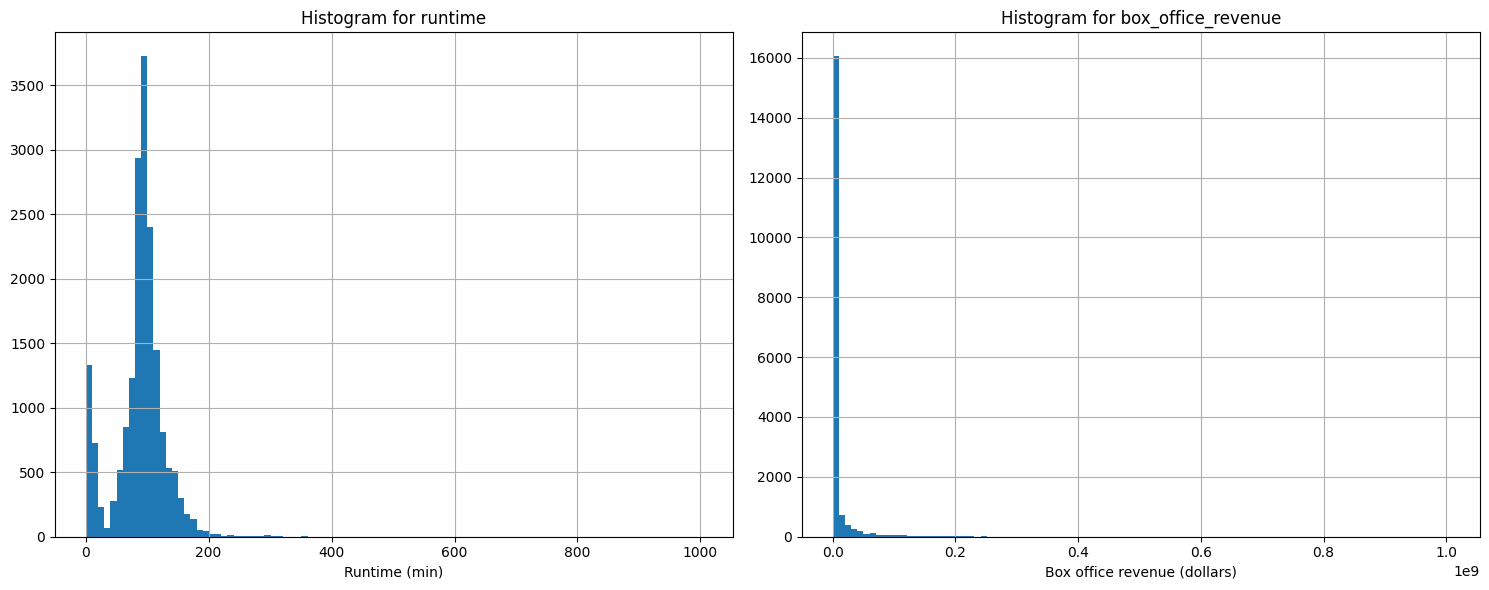

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram for the runtime
movie_data_completed["runtime"].hist(bins=100, ax=axes[0])
axes[0].set_title("Histogram for runtime")
axes[0].set_xlabel("Runtime (min)")

# Histogram for the box office results
movie_data_completed["box_office_revenue"].hist(bins=100, ax=axes[1])
axes[1].set_title("Histogram for box_office_revenue")
axes[1].set_xlabel("Box office revenue (dollars)")

plt.tight_layout()
plt.show()


Let's now print some box plots.

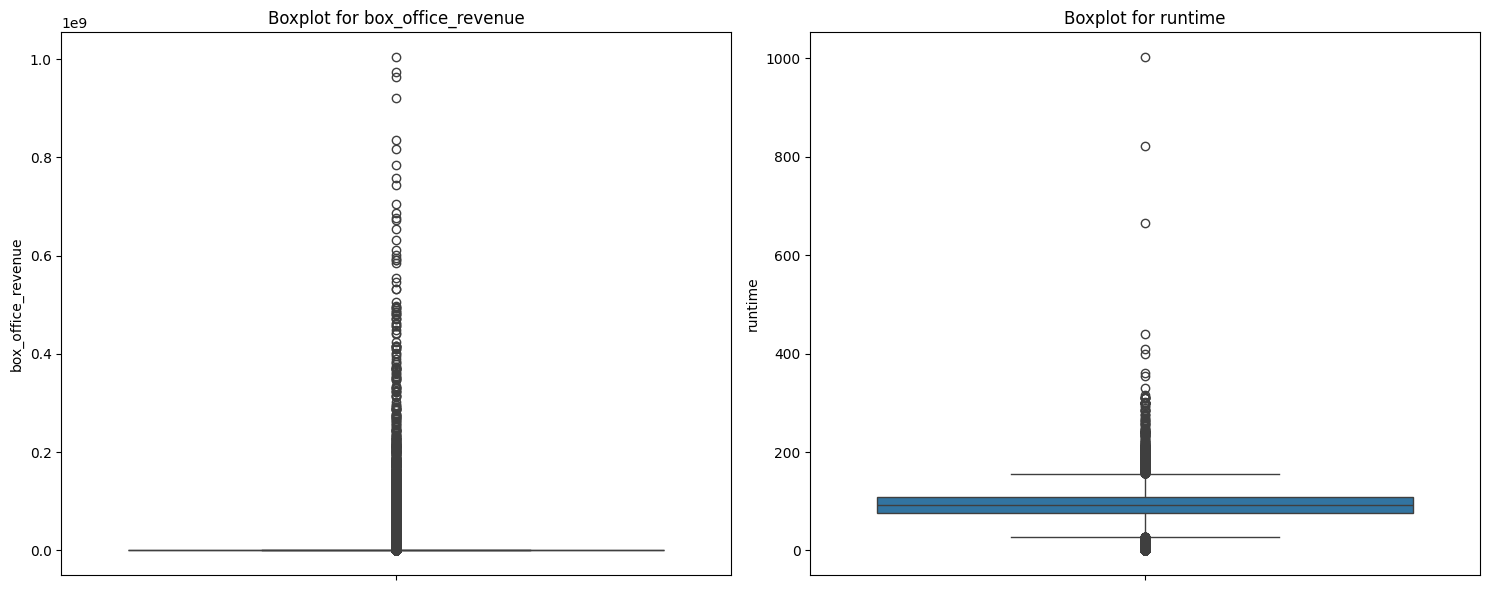

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot for the raw box_office_revenue
sns.boxplot(data=movie_data_completed["box_office_revenue"], ax=axes[0])
axes[0].set_title("Boxplot for box_office_revenue")

# Boxplot for the raw runtime
sns.boxplot(data=movie_data_completed["runtime"], ax=axes[1])
axes[1].set_title("Boxplot for runtime")

plt.tight_layout()
plt.show()


We can now have a look to the categorical features:

In [79]:
#TODO: SOME COUNT PLOTS FOR CATEGORICAL

### Characters dataset

In [80]:
# TODO